# Imports

In [23]:
from pathlib import Path
import pandas as pd
from xml.etree import ElementTree as ET
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import re



DATA_ROOT = Path("KWS")

# Load the .tsv files and build a word table

In [24]:
# 1) Load transcription table: word_id -> transcription
trans_df = pd.read_csv(
    DATA_ROOT / "transcription.tsv",
    sep="\t",
    header=None,
    names=["word_id", "transcription"],
    dtype=str,
)

print("Transcriptions:")
print(trans_df.head())

# 2) Load train / validation document lists
train_docs = pd.read_csv(
    DATA_ROOT / "train.tsv",
    sep="\t",
    header=None,
    names=["doc_id"],
    dtype=str,
)

val_docs = pd.read_csv(
    DATA_ROOT / "validation.tsv",
    sep="\t",
    header=None,
    names=["doc_id"],
    dtype=str,
)

train_doc_set = set(train_docs["doc_id"])
val_doc_set = set(val_docs["doc_id"])

print("Number of train docs:", len(train_doc_set))
print("Number of val docs:", len(val_doc_set))

# 3) Split word_id into (doc, line, word)
def split_word_id(word_id: str):
    """
    Split an ID like '270-05-07' into (doc_id, line_id, word_idx).
     Args:
        word_id (str): Word ID in the format 'doc-line-word'.
     Returns:
        tuple: (doc_id, line_id, word_idx)
    """
    doc, line, word = word_id.split("-")
    return doc, line, word

words_df = trans_df.copy()
words_df[["doc_id", "line_id", "word_idx"]] = (
    words_df["word_id"]
    .apply(split_word_id)
    .apply(pd.Series)
)

# 4) Assign split based on document id
def get_split(doc_id: str) -> str:
    """
    Determine the data split for a given document ID.
     Args:
        doc_id (str): Document ID.
     Returns:
        str: "train", "val", or "unknown".
    """
    if doc_id in train_doc_set:
        return "train"
    elif doc_id in val_doc_set:
        return "val"
    else:
        return "unknown"

words_df["split"] = words_df["doc_id"].apply(get_split)

print("\nWords DataFrame:")
print(words_df.head())
print("\nSplit value counts:")
print(words_df["split"].value_counts())


Transcriptions:
     word_id                 transcription
0  270-01-01              s_2-s_7-s_0-s_pt
1  270-01-02            L-e-t-t-e-r-s-s_cm
2  270-01-03                   O-r-d-e-r-s
3  270-01-04                         a-n-d
4  270-01-05  I-n-s-t-r-u-c-t-i-o-n-s-s_pt
Number of train docs: 10
Number of val docs: 5

Words DataFrame:
     word_id                 transcription doc_id line_id word_idx  split
0  270-01-01              s_2-s_7-s_0-s_pt    270      01       01  train
1  270-01-02            L-e-t-t-e-r-s-s_cm    270      01       02  train
2  270-01-03                   O-r-d-e-r-s    270      01       03  train
3  270-01-04                         a-n-d    270      01       04  train
4  270-01-05  I-n-s-t-r-u-c-t-i-o-n-s-s_pt    270      01       05  train

Split value counts:
split
train    2433
val      1293
Name: count, dtype: int64


# Extract images of words

## Path

In [25]:
IMAGES_DIR = DATA_ROOT / "images"
LOCATIONS_DIR = DATA_ROOT / "locations"

## Find the page image and SVG for a document

In [26]:
def find_page_image(doc_id: str) -> Image.Image:
    """
    Return the PIL image for a given document id.
    
    Args:
        doc_id (str): Document identifier, e.g. "270".
    
    Returns:
        Image.Image: Grayscale page image.
    """
    exts = ("png", "jpg", "jpeg", "tif", "tiff", "bmp")
    for ext in exts:
        candidates = list(IMAGES_DIR.glob(f"*{doc_id}*.{ext}"))
        if candidates:
            img_path = candidates[0]
            return Image.open(img_path).convert("L")  # grayscale
    raise FileNotFoundError(f"No page image found for doc_id={doc_id!r}")


def find_svg_for_doc(doc_id: str) -> Path:
    """
    Return the SVG file path for a given document id.
    
    Args:
        doc_id (str): Document identifier, e.g. "270".
    
    Returns:
        Path: Path to the SVG file.
    """
    candidates = list(LOCATIONS_DIR.glob(f"*{doc_id}*.svg"))
    if not candidates:
        raise FileNotFoundError(f"No SVG found for doc_id={doc_id!r}")
    if len(candidates) > 1:
        print(f"Warning: multiple SVGs for doc {doc_id}, using {candidates[0].name}")
    return candidates[0]


## Retrieve the polygon of a word in SVG

In [27]:
def get_word_polygon(doc_id: str, word_id: str):
    """
    Parse the SVG for a given document and extract polygon points for a word.

    Each word is a <path> element with:
        id="DDD-LL-WW"
        d="M x y L x y L x y ... Z"
    
    Args:
        doc_id (str): Document id, e.g. "270".
        word_id (str): Word id, e.g. "270-05-07".
    
    Returns:
        list(tuple[float, float]): List of (x, y) polygon points.
    """    
    svg_path = find_svg_for_doc(doc_id)
    tree = ET.parse(svg_path)
    root = tree.getroot()

    target_elem = None
    for elem in root.iter():
        if elem.attrib.get("id") == word_id:
            target_elem = elem
            break

    if target_elem is None:
        raise ValueError(f"Word id {word_id!r} not found in {svg_path.name}")

    d = target_elem.attrib.get("d")
    if d is None:
        print(f"[DEBUG] Element for {word_id!r} in {svg_path.name}:")
        print("  tag:", target_elem.tag)
        print("  attrib:", target_elem.attrib)
        raise ValueError(f"No 'd' attribute for word {word_id!r} (expected <path d='...'>)")

    # Extract all numbers in d (ignore M/L/Z etc.)
    nums = re.findall(r"[-+]?\d*\.?\d+", d)
    if len(nums) < 4:
        raise ValueError(f"Not enough coordinates in path 'd' for word {word_id!r}")

    coords = list(map(float, nums))
    # Group as (x1, y1), (x2, y2), ...
    pts = list(zip(coords[0::2], coords[1::2]))
    return pts

## Cropping the word image from the polygon

In [28]:
def crop_word_image(page_img: Image.Image, polygon, padding: int = 2) -> Image.Image:
    """
    Crop a word image from the page given its polygon.
    
    Args:
        page_img (Image.Image): Full page (grayscale) image.
        polygon (list[tuple[float, float]]): List of (x, y) coordinates defining the word polygon.
        padding (int): Extra pixels to extend the bounding box on each side.
    
    Returns:
        Image.Image: Cropped word image.
    """
    xs = [p[0] for p in polygon]
    ys = [p[1] for p in polygon]

    left = max(int(min(xs)) - padding, 0)
    right = min(int(max(xs)) + padding, page_img.width)
    top = max(int(min(ys)) - padding, 0)
    bottom = min(int(max(ys)) + padding, page_img.height)

    return page_img.crop((left, top, right, bottom))


## Obtain the image of a word

In [29]:
def get_word_image(word_row, padding: int = 2) -> Image.Image:
    """
    Convenience function: from a row of words_df, return the cropped word image.
    
    Args:
        word_row (pandas.Series):Row from words_df with fields 'word_id' and 'doc_id'.
        padding (int): Extra pixels around the bounding box.
    
    Returns:
        Image.Image: Cropped word image.
    """
    doc_id = word_row["doc_id"]
    word_id = word_row["word_id"]

    page_img = find_page_image(doc_id)
    polygon = get_word_polygon(doc_id, word_id)
    word_img = crop_word_image(page_img, polygon, padding=padding)
    return word_img


## Tests

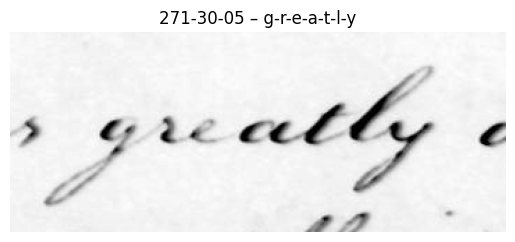

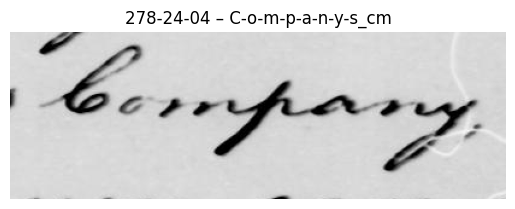

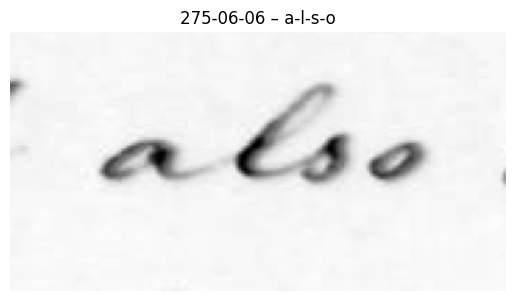

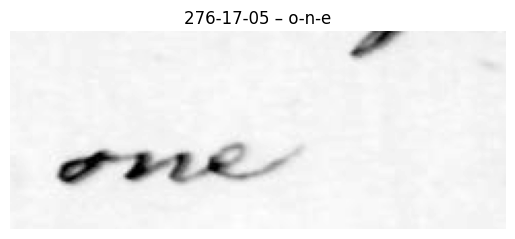

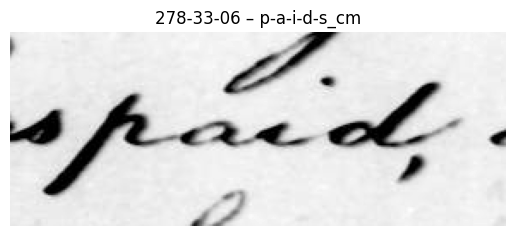

In [30]:

# Pick a few random words from training set
sample_rows = words_df[words_df["split"] == "train"].sample(5, random_state=3)

for _, row in sample_rows.iterrows():
    img = get_word_image(row, padding=3)
    plt.figure()
    plt.title(f"{row['word_id']} – {row['transcription']}")
    plt.imshow(img, cmap="gray")
    plt.axis("off")
